# Modelling

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import math

In [72]:
season_14 = pd.read_csv("../data/clean_2014_season.csv")
season_15 = pd.read_csv("../data/clean_2015_season.csv")
season_16 = pd.read_csv("../data/clean_2016_season.csv")
season_17 = pd.read_csv("../data/clean_2017_season.csv")
season_18 = pd.read_csv("../data/clean_2018_season.csv")
season_19 = pd.read_csv("../data/clean_2019_season.csv")
season_20 = pd.read_csv("../data/clean_2020_season.csv")
season_21 = pd.read_csv("../data/clean_2021_season.csv")
season_22 = pd.read_csv("../data/clean_2022_season.csv")
season_23 = pd.read_csv("../data/clean_2023_season.csv")
season_24 = pd.read_csv("../data/clean_2024_season.csv")

## 1. Model preparation
Use the 2023/24 season as the training set, and the 2024/25 season as the test set.
### 1.1. Concatenation

In [73]:
# Concatenate the two seasons together
all_seasons = pd.concat([season_14, season_15, season_16, season_17, season_18, season_19, season_20, season_21, season_22, season_23, season_24], ignore_index=True)
# Sort by year, then by week
all_seasons = all_seasons.sort_values(['year', 'Week']).reset_index(drop=True)

In [74]:
# Check datatype of columns
print(all_seasons.dtypes)

Week               int64
Day               object
Date              object
year               int64
sf_rec           float64
opp_rec          float64
Opp               object
score_tm         float64
score_opp        float64
offense_1stD     float64
offense_totYd    float64
offense_passY    float64
offense_rushY    float64
offense_to       float64
defense_1stD     float64
defense_totYd    float64
defence_passY    float64
defense_rushY    float64
defense_to       float64
ep_offense       float64
ep_defense       float64
ep_sp_Tms        float64
win_lose           int64
home_away          int64
point_diff       float64
turnover_diff    float64
dtype: object


### 1.2. Pre-game rolling features

In [75]:
all_seasons.columns

Index(['Week', 'Day', 'Date', 'year', 'sf_rec', 'opp_rec', 'Opp', 'score_tm',
       'score_opp', 'offense_1stD', 'offense_totYd', 'offense_passY',
       'offense_rushY', 'offense_to', 'defense_1stD', 'defense_totYd',
       'defence_passY', 'defense_rushY', 'defense_to', 'ep_offense',
       'ep_defense', 'ep_sp_Tms', 'win_lose', 'home_away', 'point_diff',
       'turnover_diff'],
      dtype='object')

In [76]:
def add_rolling_features(df, cols, window = 3, prefix = 'sf'):
    df = df.sort_values(['year', 'Week'])
    for col in cols:
        df[f'{prefix}_roll{window}_{col}'] = (
            df.groupby('year')[col]
            .transform(lambda s: s.shift().rolling(window=window, min_periods=1).mean())
        )
    return df

rolling_sources_cols = ['score_tm', 'score_opp', 'offense_totYd', 'defense_totYd', 'turnover_diff', 'point_diff']
all_seasons = add_rolling_features(all_seasons, rolling_sources_cols, window=3, prefix='sf')

### 1.3. Opponent strength proxy

In [77]:
all_seasons['opp_win_pct_before'] = np.where(all_seasons['Week']>1, all_seasons['opp_rec'] / (all_seasons['Week']-1), 0.5)
all_seasons['sf_win_pct_before'] = np.where(all_seasons['Week']>1, all_seasons['sf_rec'] / (all_seasons['Week']-1), 0.5)

### 1.4. Define features & targets

In [78]:
feature_cols = [
    'home_away',
    'opp_win_pct_before','sf_win_pct_before',
    'sf_roll3_offense_totYd','sf_roll3_defense_totYd',
    'sf_roll3_turnover_diff','sf_roll3_score_tm','sf_roll3_score_opp'
]

# Train on 2023, test on 2024
train = all_seasons[(all_seasons['year']>=2014) & (all_seasons['year'] <= 2023)].copy()
test  = all_seasons[all_seasons['year']==2024].copy()

X_train = train[feature_cols].fillna(method='bfill').fillna(method='ffill')
X_test  = test[feature_cols].fillna(method='bfill').fillna(method='ffill')

y_reg_train = train['score_tm']
y_reg_test  = test['score_tm']

y_clf_train = train['win_lose'].astype(int)
y_clf_test  = test['win_lose'].astype(int)

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_9732/1702508986.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = train[feature_cols].fillna(method='bfill').fillna(method='ffill')
/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_9732/1702508986.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = test[feature_cols].fillna(method='bfill').fillna(method='ffill')


## 2. Baseline regression

In [79]:
# Linear baseline
lin = LinearRegression()
lin.fit(X_train, y_reg_train)
pred_lin = lin.predict(X_test)

mae_lin = mean_absolute_error(y_reg_test, pred_lin)
rmse_lin = math.sqrt(mean_squared_error(y_reg_test, pred_lin))
r2_lin = r2_score(y_reg_test, pred_lin)

# Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=500, max_depth=None, random_state=42
)
rf_reg.fit(X_train, y_reg_train)
pred_rf = rf_reg.predict(X_test)

mae_rf  = mean_absolute_error(y_reg_test, pred_rf)
rmse_rf = math.sqrt(mean_squared_error(y_reg_test, pred_rf))
r2_rf   = r2_score(y_reg_test, pred_rf)

print({
    'Linear': {'MAE': mae_lin, 'RMSE': rmse_lin, 'R2': r2_lin},
    'RF':     {'MAE': mae_rf,  'RMSE': rmse_rf,  'R2': r2_rf}
})

{'Linear': {'MAE': 8.364115770050532, 'RMSE': 9.641554802079048, 'R2': -0.022631267430808455}, 'RF': {'MAE': 8.405125, 'RMSE': 9.761884692517116, 'R2': -0.048316124962399565}}


## 3. Predict win porbability

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

# Logistic baseline
logit = LogisticRegression(max_iter=500, solver='liblinear')
logit.fit(X_train, y_clf_train)
proba_logit = logit.predict_proba(X_test)[:,1]
pred_logit  = (proba_logit >= 0.5).astype(int)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=500, max_depth=None, random_state=42
)
rf_clf.fit(X_train, y_clf_train)
proba_rf = rf_clf.predict_proba(X_test)[:,1]
pred_rf_c = (proba_rf >= 0.5).astype(int)

def summary(y_true, y_prob, y_hat):
    return dict(
        ACC = accuracy_score(y_true, y_hat),
        ROC_AUC = roc_auc_score(y_true, y_prob),
        LOGLOSS = log_loss(y_true, y_prob)
    )

print({
    'Logit': summary(y_clf_test, proba_logit, pred_logit),
    'RF':    summary(y_clf_test, proba_rf,    pred_rf_c)
})

{'Logit': {'ACC': 0.6875, 'ROC_AUC': 0.7833333333333333, 'LOGLOSS': 0.6311003744239689}, 'RF': {'ACC': 0.75, 'ROC_AUC': 0.9, 'LOGLOSS': 0.5163566025762133}}


## 4. Visualisations

### 4.1. ROC Curve

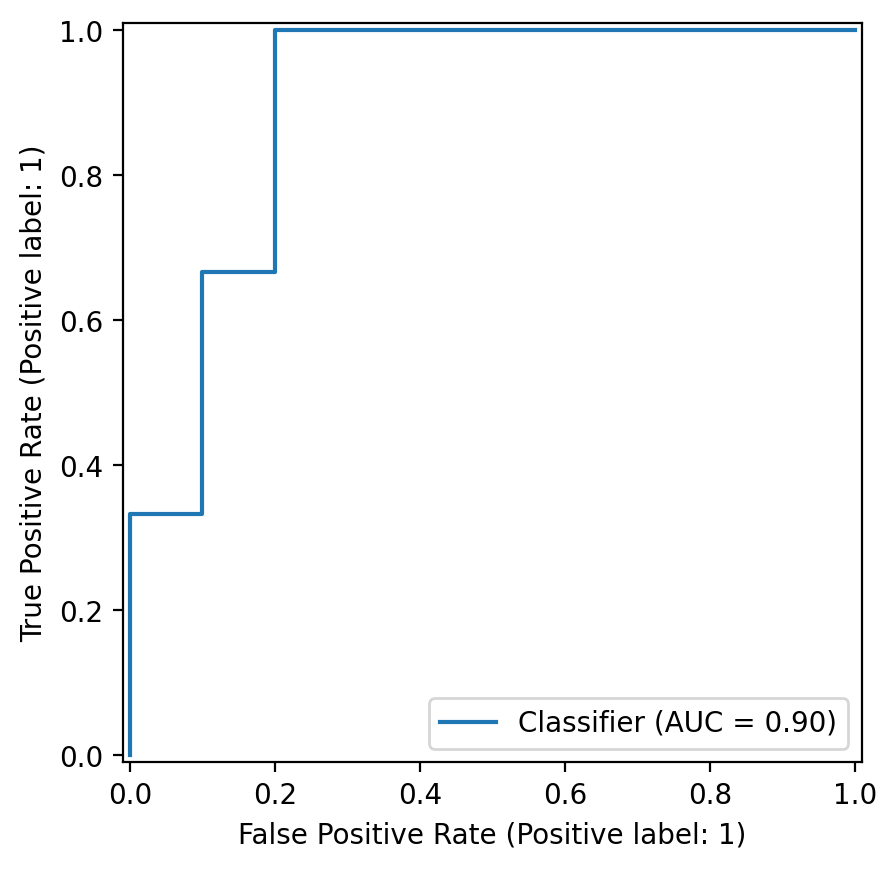

In [81]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_clf_test, proba_rf)
#plt.title("ROC Curve – Random Forest Classifier (Win/Loss)")
plt.show()

### 4.2 Confusion Matrix

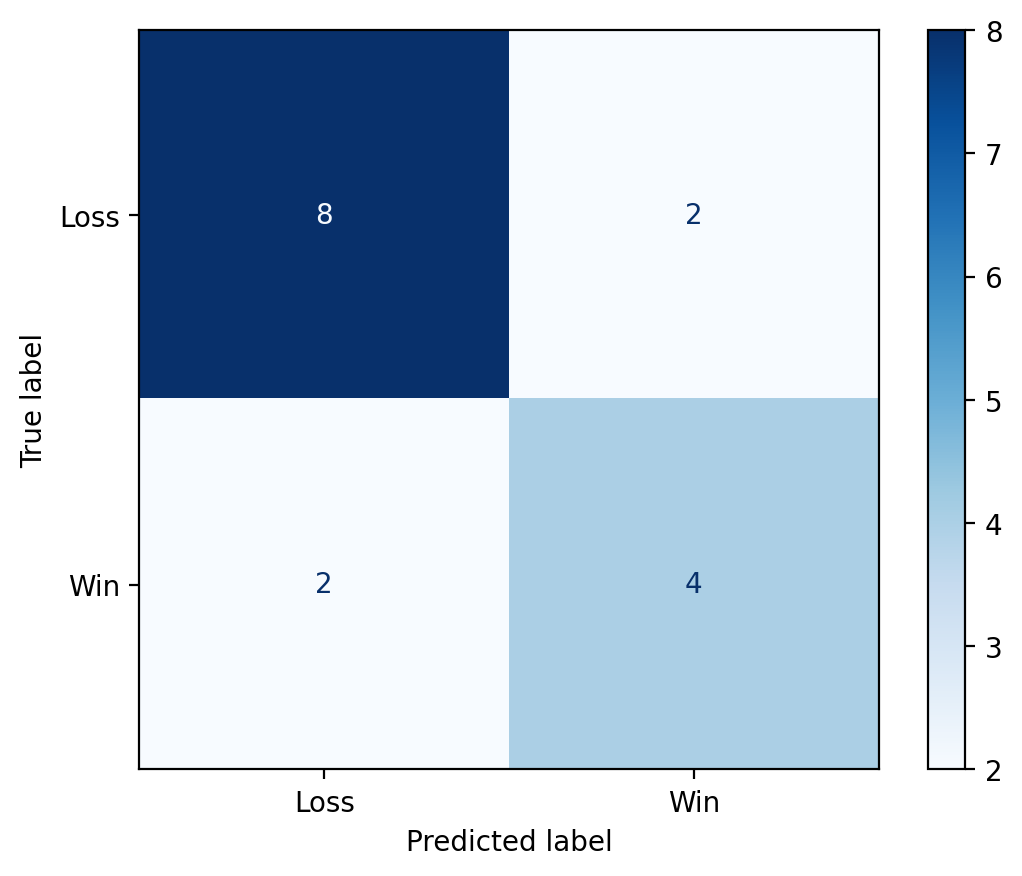

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_clf_test, pred_rf_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss","Win"])
disp.plot(cmap="Blues", values_format="d")
#plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### 4.3. Feature Importance

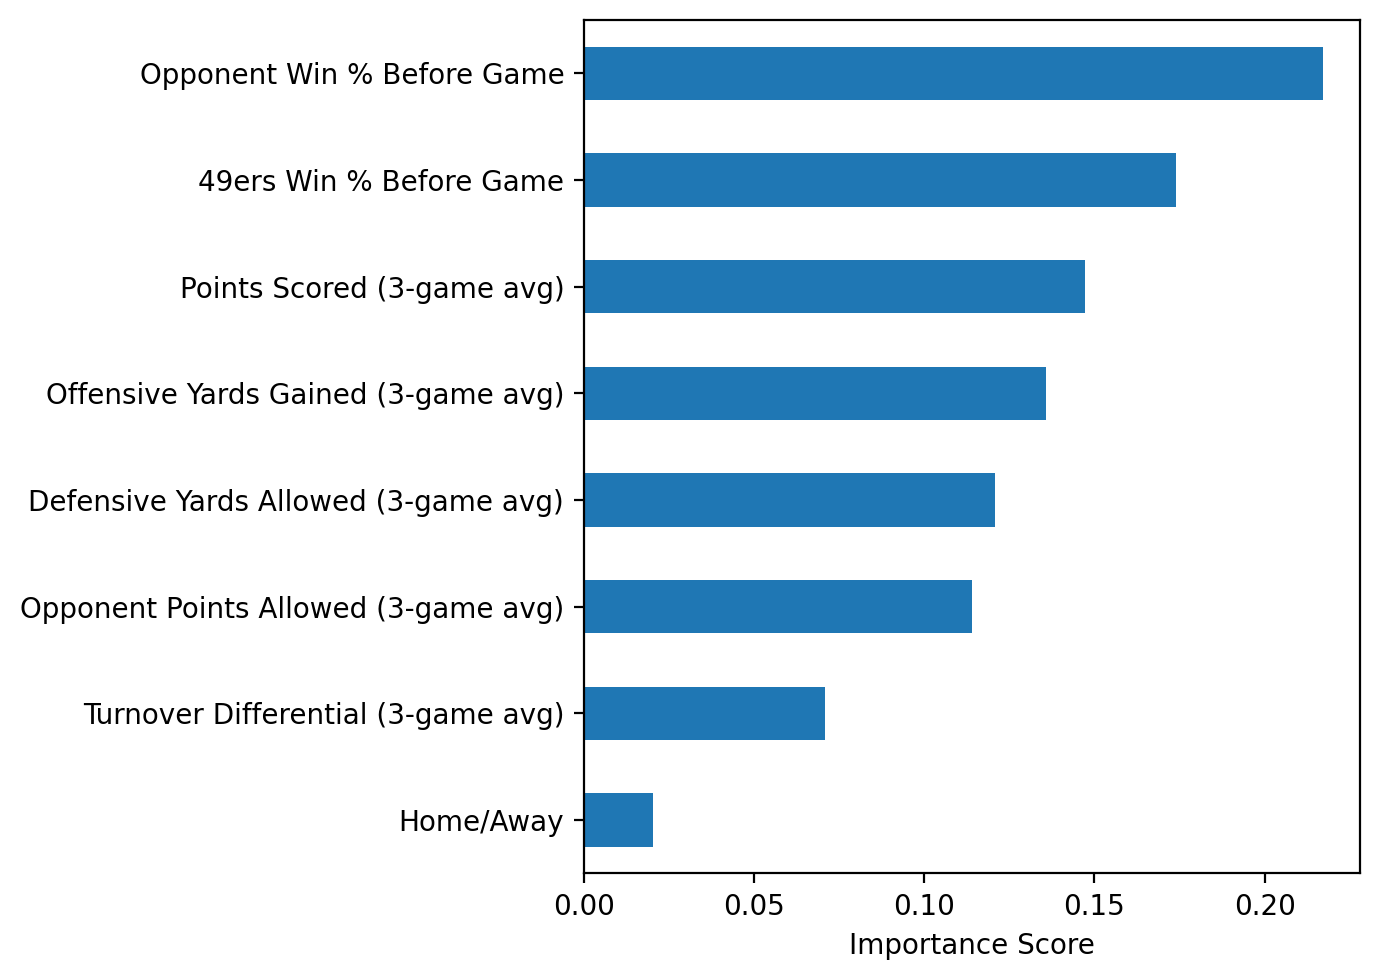

In [83]:
label_map = {
    "home_away": "Home/Away",
    "sf_roll3_turnover_diff": "Turnover Differential (3-game avg)",
    "sf_roll3_defense_totYd": "Defensive Yards Allowed (3-game avg)",
    "sf_roll3_score_opp": "Opponent Points Allowed (3-game avg)",
    "sf_roll3_score_tm": "Points Scored (3-game avg)",
    "sf_roll3_offense_totYd": "Offensive Yards Gained (3-game avg)",
    "sf_win_pct_before": "49ers Win % Before Game",
    "opp_win_pct_before": "Opponent Win % Before Game"
}

importances = pd.Series(rf_clf.feature_importances_, index=X_test.columns)
importances = importances.sort_values(ascending=True)

# Map to clean labels
importances.index = importances.index.map(lambda x: label_map.get(x, x))

plt.figure(figsize=(7,5))
importances.plot(kind="barh")
#plt.title("Feature Importance – Random Forest Classifier")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [84]:
print(importances)

Home/Away                               0.020456
Turnover Differential (3-game avg)      0.070880
Opponent Points Allowed (3-game avg)    0.113951
Defensive Yards Allowed (3-game avg)    0.120702
Offensive Yards Gained (3-game avg)     0.135703
Points Scored (3-game avg)              0.147354
49ers Win % Before Game                 0.173845
Opponent Win % Before Game              0.217108
dtype: float64


### 4.4. Season-level win rate

In [85]:
season_summary = (
    all_seasons.groupby("year")["win_lose"]
    .mean()   # proportion of games won
    .reset_index(name="win_rate")
)

In [86]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = season_summary["year"].values.reshape(-1, 1)
y = season_summary["win_rate"].values

lin_trend = LinearRegression()
lin_trend.fit(X, y)

# Predict next season (2025)
next_year = np.array([[2025]])
pred_2025 = lin_trend.predict(next_year)[0]

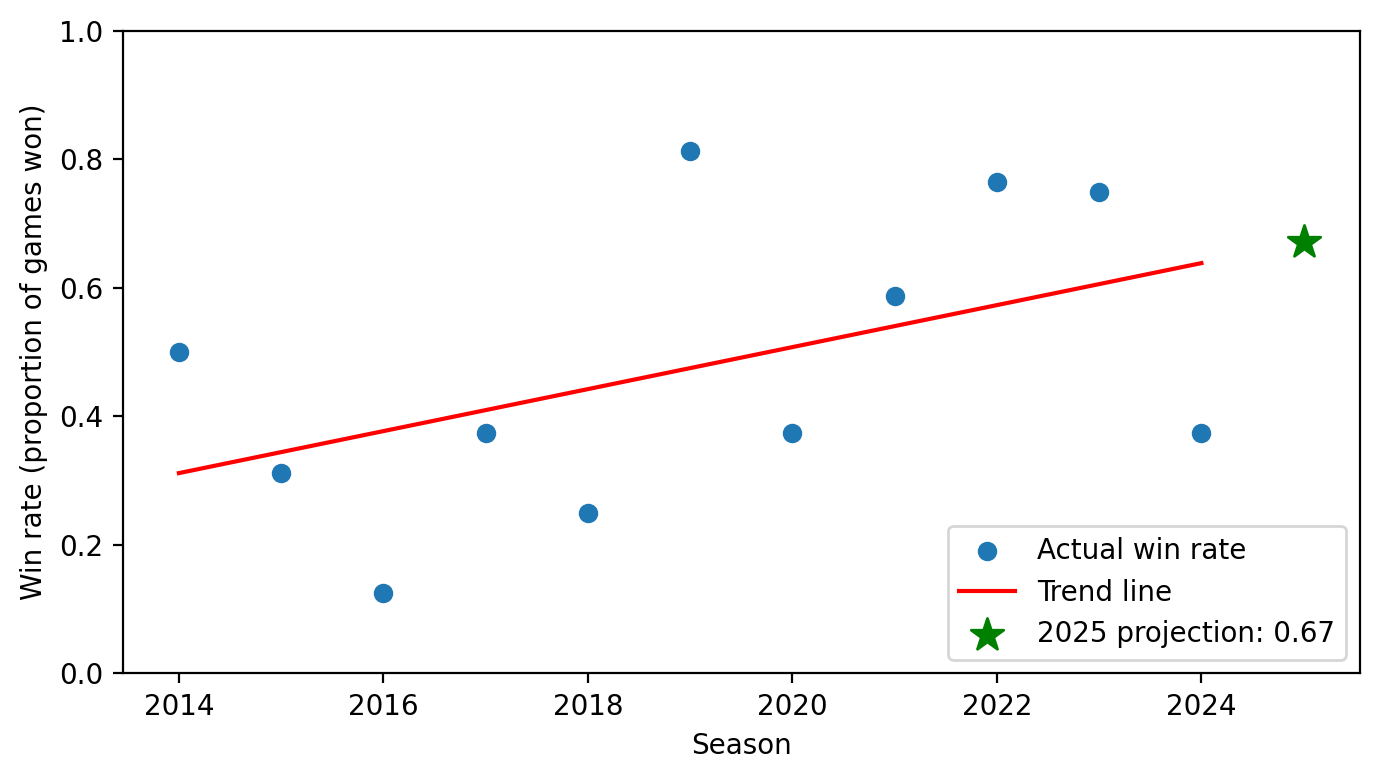

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.scatter(season_summary["year"], season_summary["win_rate"], label="Actual win rate")
plt.plot(season_summary["year"], lin_trend.predict(X), color="red", label="Trend line")
plt.scatter(2025, pred_2025, color="green", marker="*", s=150, label=f"2025 projection: {pred_2025:.2f}")

plt.ylim(0,1)
plt.ylabel("Win rate (proportion of games won)")
plt.xlabel("Season")
#plt.title("49ers Win Rate Trend (2014-2024 with 2025 Projection)")
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

In [89]:
print(season_summary)

    year  win_rate
0   2014  0.500000
1   2015  0.312500
2   2016  0.125000
3   2017  0.375000
4   2018  0.250000
5   2019  0.812500
6   2020  0.375000
7   2021  0.588235
8   2022  0.764706
9   2023  0.750000
10  2024  0.375000
